# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **IBRD Credit Scorecard Predictive Engine** |

# II. Notebook Target Definition

This notebook delineates the model training and evaluation stage of IBRD Credit Scorecard Predictive Engine Project. Here, we train and test predictive models on our preprocessed and feature-engineered loan data. We leverage metrics such as confusion matrix, ROC-AUC, and F1 score to gauge model performance. The trade-offs between various types of prediction errors are evaluated to choose the most suitable model, in line with our business needs. The result is a robust model capable of effectively predicting loans most likely to be cancelled or terminated, fostering more informed loan management decisions.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from skopt import BayesSearchCV
from tqdm import tqdm
import hashlib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## III.B. Import Data

In [2]:
X_train = pd.read_pickle('../../data/processed/X_train_ohe.pkl')
X_test = pd.read_pickle('../../data/processed/X_test_ohe.pkl')
y_train = pd.read_pickle('../../data/processed/y_train.pkl')
y_test = pd.read_pickle('../../data/processed/y_test.pkl')

In [3]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:WESTERN AND CENTRAL AFRICA,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_a,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:40215236.00_to_54947816.00,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor,country_guarantor_status:same
8919,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
289,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2266,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
838,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
94,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [4]:
X_test.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:WESTERN AND CENTRAL AFRICA,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_a,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:40215236.00_to_54947816.00,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor,country_guarantor_status:same
219,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3628,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
497,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
5583,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1556,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [5]:
y_train.head()

8919    0
289     0
2266    0
838     0
94      0
Name: bad, dtype: int32

In [6]:
y_test.head()

219     0
3628    0
497     0
5583    0
1556    0
Name: bad, dtype: int32

# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [7]:
X_train.shape, X_test.shape

((4704, 40), (2017, 40))

In [8]:
y_train.shape, y_test.shape

((4704,), (2017,))

## IV.B. Data Information Inspection

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4704 entries, 8919 to 6608
Data columns (total 40 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC  4704 non-null   int32
 1   region:EUROPE AND CENTRAL ASIA & SOUTH ASIA                 4704 non-null   int32
 2   region:LATIN AMERICA AND CARIBBEAN                          4704 non-null   int32
 3   region:MIDDLE EAST AND NORTH AFRICA                         4704 non-null   int32
 4   region:WESTERN AND CENTRAL AFRICA                           4704 non-null   int32
 5   country:group_a                                             4704 non-null   int32
 6   country:group_b                                             4704 non-null   int32
 7   country:group_c                                             4704 non-null   int32
 8   country:group_d     

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 219 to 1162
Data columns (total 40 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC  2017 non-null   int32
 1   region:EUROPE AND CENTRAL ASIA & SOUTH ASIA                 2017 non-null   int32
 2   region:LATIN AMERICA AND CARIBBEAN                          2017 non-null   int32
 3   region:MIDDLE EAST AND NORTH AFRICA                         2017 non-null   int32
 4   region:WESTERN AND CENTRAL AFRICA                           2017 non-null   int32
 5   country:group_a                                             2017 non-null   int32
 6   country:group_b                                             2017 non-null   int32
 7   country:group_c                                             2017 non-null   int32
 8   country:group_d      

In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4704 entries, 8919 to 6608
Series name: bad
Non-Null Count  Dtype
--------------  -----
4704 non-null   int32
dtypes: int32(1)
memory usage: 55.1 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 2017 entries, 219 to 1162
Series name: bad
Non-Null Count  Dtype
--------------  -----
2017 non-null   int32
dtypes: int32(1)
memory usage: 23.6 KB


## IV.C. Training Log

In [13]:
def time_stamp():
    return datetime.now()

def create_logger():
    return {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "performance": [],
        "f1_score_avg": [],
        "data_configurations": []
    }

def training_log_updater(current_log, log_path):
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
    except FileNotFoundError:
        with open(log_path, "w") as file:
            file.write("[]")
        with open(log_path, "r") as file:
            last_log = json.load(file)
    last_log.append(current_log)
    with open(log_path, "w") as file:
        json.dump(last_log, file)
    return last_log

def model_training_and_evaluation(models_list, model_prefix, X_train, y_train, X_test, y_test, data_configuration, log_path):
    logger = create_logger()
    for model in tqdm(models_list):
        model_name = model_prefix + "-" + model["model_name"]
        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()
        elapsed_time = (finished_time - start_time).total_seconds()
        y_prediction = model["model_object"].predict(X_test)
        performance = classification_report(y_test, y_prediction, output_dict = True)
        original_id = str(start_time) + str(finished_time)
        hashed_id = hashlib.md5(original_id.encode()).hexdigest()
        model["model_uid"] = hashed_id
        logger["model_name"].append(model_name)
        logger["model_uid"].append(hashed_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration)
    training_log = training_log_updater(logger, log_path)
    return training_log, models_list

def training_log_to_df_converter(training_log):
    all_training_logs_df = pd.DataFrame()
    for log in tqdm(training_log):
        individual_log_df = pd.DataFrame(log)
        performance_df = pd.json_normalize(individual_log_df["performance"])
        individual_log_df = pd.concat([individual_log_df.drop("performance", axis = 1), performance_df], axis = 1)
        all_training_logs_df = pd.concat([all_training_logs_df, individual_log_df])
    all_training_logs_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    all_training_logs_df.reset_index(inplace = True, drop = True)
    return all_training_logs_df

def best_model_finder(all_training_logs_df, models_list):
    model_object = None
    best_model_info = all_training_logs_df.iloc[0]
    for configuration_data in models_list:
        for model_data in models_list[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    return model_object

def tuned_model_finder(models_list_tuned, tuning_method):
    for model in models_list_tuned:
        if tuning_method in model["model_name"]:
            return model["model_object"]
    print(f"No model found that was tuned with {tuning_method}")
    return None

## IV.D. Baseline Models

In [14]:
X_train_ori = X_train.copy()
X_test_ori = X_test.copy()

In [15]:
reference_categories = ["region:WESTERN AND CENTRAL AFRICA", "country:group_a", "guarantor:group_a", "loan_type:group_a", "principal_amount:40215236.00_to_54947816.00", "country_guarantor_status:same"]

In [16]:
X_train = X_train.drop(columns = reference_categories)
X_test = X_test.drop(columns = reference_categories)
X_train.shape, X_test.shape

((4704, 34), (2017, 34))

In [17]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
8919,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
289,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2266,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
838,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
94,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [18]:
X_test.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
219,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3628,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
497,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5583,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1556,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [19]:
log_reg_baseline = LogisticRegression()

In [20]:
models_list = {
    "vanilla": [
        {"model_name": log_reg_baseline.__class__.__name__, "model_object": log_reg_baseline, "model_uid": ""},
    ]
}

In [21]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(),
   'model_uid': ''}]}

### IV.D.1. Vanilla Models

In [22]:
training_log, models_list_vanilla = model_training_and_evaluation(
    models_list["vanilla"],
    "baseline_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "vanilla",
    '../../models/logs/training_log.json')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.83it/s]


In [23]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(),
   'model_uid': '460b81acab3c3939a5ad4b0801884622'}]}

## IV.E. Models Selection

### IV.E.1. Benchmark Performance Review

In [24]:
benchmark = y_train.value_counts(normalize = True)[0]
benchmark

0.9587585034013606

### IV.E.2. Baseline Best Model Performance Review

In [25]:
all_training_logs_df = training_log_to_df_converter(training_log)
all_training_logs_df.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.25it/s]


(1, 23)

In [26]:
all_training_logs_df

,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,baseline_model-LogisticRegression,460b81acab3c3939a5ad4b0801884622,0.031615,2023-06-30 00:28:18.168191,0.556641,vanilla,0.955875,0.958583,0.996886,0.977359,1927,0.538462,0.077778,0.135922,90,0.748522,0.537332,0.556641,2017,0.939837,0.955875,0.939814,2017


In [27]:
baseline_best_model = best_model_finder(all_training_logs_df, models_list)
baseline_best_model

LogisticRegression()

In [28]:
baseline_train_prediction = baseline_best_model.predict(X_train)
baseline_test_prediction = baseline_best_model.predict(X_test)

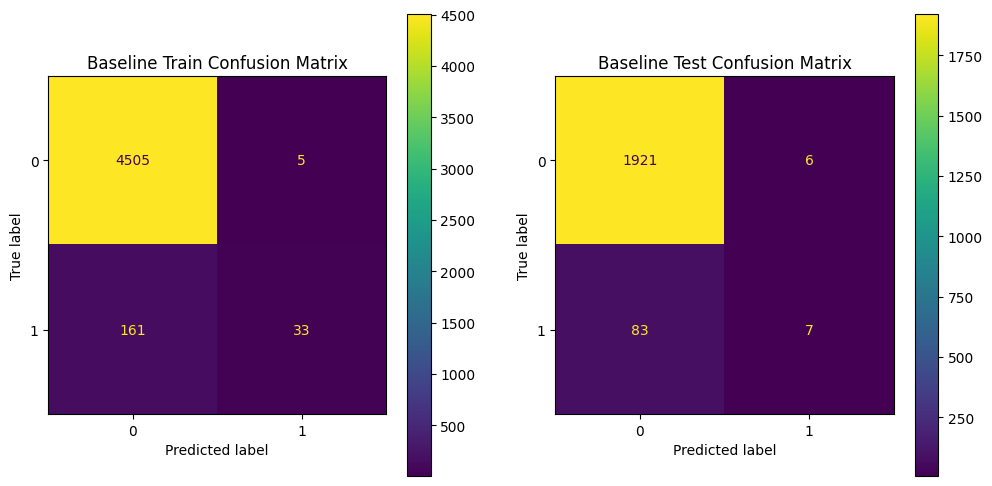

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ConfusionMatrixDisplay.from_predictions(y_train, baseline_train_prediction, ax = ax[0])
ax[0].set_title("Baseline Train Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, baseline_test_prediction, ax = ax[1])
ax[1].set_title("Baseline Test Confusion Matrix")
plt.show()

In [30]:
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict = True)
    accuracy = accuracy_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    metrics = {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": accuracy,
        "auc_roc": auc_roc
    }
    return metrics

In [31]:
baseline_train_metrics = get_metrics(y_train, baseline_train_prediction)
baseline_train_metrics["dataset"] = "Train"
baseline_test_metrics = get_metrics(y_test, baseline_test_prediction)
baseline_test_metrics["dataset"] = "Test"
baseline_metrics_df = pd.DataFrame([baseline_train_metrics, baseline_test_metrics])
baseline_metrics_df

,precision,recall,f1-score,accuracy,auc_roc,dataset
0,0.961492,0.964711,0.953146,0.964711,0.584497,Train
1,0.939837,0.955875,0.939814,0.955875,0.537332,Test


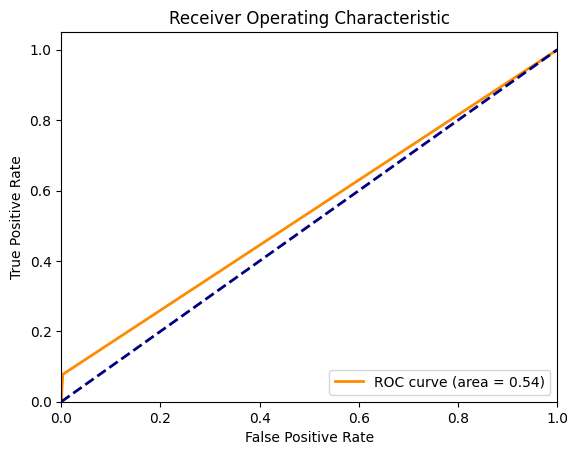

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, baseline_test_prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,
         tpr,
         color = 'darkorange',
         lw = 2,
         label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         color = 'navy',
         lw = 2,
         linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = 'lower right')
plt.show()

### IV.E.3. Baseline Best Model Bias-Variance Trade-Off Review

In [33]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [34]:
def plot_learning_curve(estimator, title, X, y, cross_validation = None):
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X,
                                                            y,
                                                            cv = cross_validation,
                                                            n_jobs = -1,
                                                            train_sizes = np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha = 0.1,
                     color = "g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color = "r",
             label = "Training Score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color = "g",
             label = "Cross-Validation Score")
    plt.legend(loc = "best")
    plt.show()

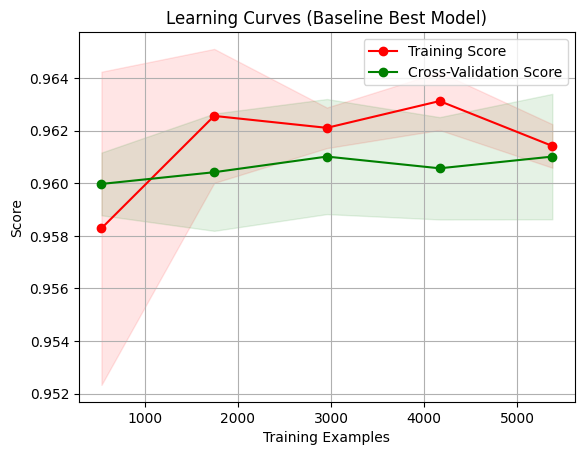

In [35]:
plot_learning_curve(baseline_best_model, "Learning Curves (Baseline Best Model)", X, y, cross_validation = 5)

### IV.E.4. Export Baseline Best Model

In [36]:
# with open("../../models/baseline_best_model.pkl", "wb") as file:
#     pickle.dump(baseline_best_model, file)

## IV.F. Hyperparameter Tuning

### IV.F.1. Bayesian Search Cross Validation

In [37]:
logistic_regression_hyperparams = {
    "C": (1e-5, 1e+5, 'log-uniform'),
    "fit_intercept": [True, False],
    "solver": ['liblinear', 'saga'],
    "penalty": ['l1', 'l2']
}

In [38]:
logistic_regression_bayes_search = BayesSearchCV(
    baseline_best_model,
    logistic_regression_hyperparams,
    n_jobs = -1,
    verbose = 420
)

In [39]:
models_list["fine-tuned"] = [
    {"model_name": logistic_regression_bayes_search.__class__.__name__ + "-" + logistic_regression_bayes_search.estimator.__class__.__name__, "model_object": logistic_regression_bayes_search, "model_uid": ""}
]

### IV.F.2. Hyperparameter-tuned Model Retraining

In [40]:
training_log, models_list_tuned = model_training_and_evaluation(
    models_list["fine-tuned"],
    "tuned_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "tuned",
    '../../models/logs/training_log.json'
)

  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.71s/it]


In [41]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(),
   'model_uid': '460b81acab3c3939a5ad4b0801884622'}],
 'fine-tuned': [{'model_name': 'BayesSearchCV-LogisticRegression',
   'model_object': BayesSearchCV(estimator=LogisticRegression(), n_jobs=-1,
                 search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                                'fit_intercept': [True, False],
                                'penalty': ['l1', 'l2'],
                                'solver': ['liblinear', 'saga']},
                 verbose=420),
   'model_uid': '0c918cdd5850813151898f46593e28de'}]}

### IV.F.3. Hyperparameter-tuned Model Performance Review

In [42]:
all_training_logs_df_tuned = training_log_to_df_converter(training_log)
all_training_logs_df_tuned.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 261.30it/s]


(2, 23)

In [43]:
all_training_logs_df_tuned

,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,tuned_model-BayesSearchCV-LogisticRegression,0c918cdd5850813151898f46593e28de,45.705369,2023-06-30 00:28:22.375958,0.583787,tuned,0.953892,0.960341,0.992735,0.976269,1927,0.440000,0.122222,0.191304,90,0.700171,0.557479,0.583787,2017,0.937123,0.953892,0.941244,2017
1,baseline_model-LogisticRegression,460b81acab3c3939a5ad4b0801884622,0.031615,2023-06-30 00:28:18.168191,0.556641,vanilla,0.955875,0.958583,0.996886,0.977359,1927,0.538462,0.077778,0.135922,90,0.748522,0.537332,0.556641,2017,0.939837,0.955875,0.939814,2017


In [44]:
models_dict_tuned = {"fine-tuned": models_list_tuned}
tuned_best_model = tuned_model_finder(models_dict_tuned['fine-tuned'], "BayesSearchCV")
tuned_best_model

BayesSearchCV(estimator=LogisticRegression(), n_jobs=-1,
              search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                             'fit_intercept': [True, False],
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga']},
              verbose=420)

In [45]:
tuned_train_prediction = tuned_best_model.predict(X_train)
tuned_test_prediction = tuned_best_model.predict(X_test)

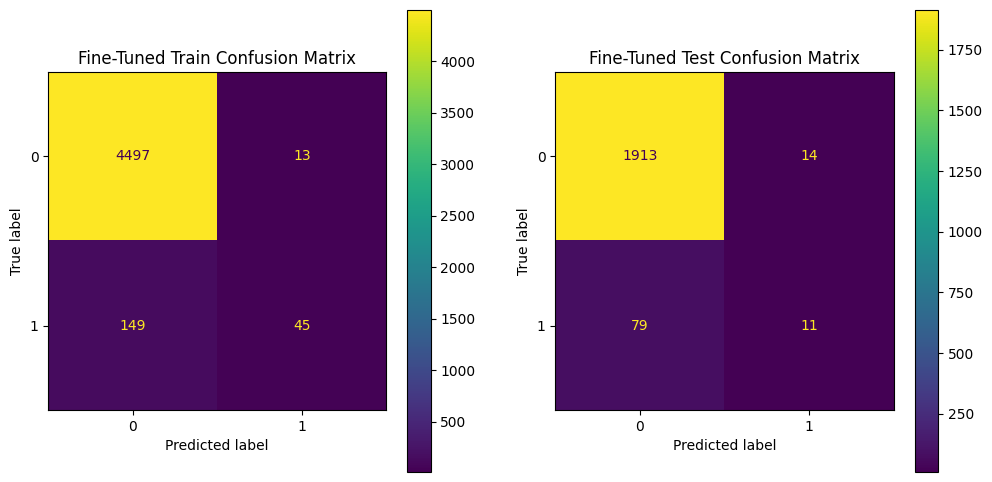

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ConfusionMatrixDisplay.from_predictions(y_train, tuned_train_prediction, ax = ax[0])
ax[0].set_title("Fine-Tuned Train Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, tuned_test_prediction, ax = ax[1])
ax[1].set_title("Fine-Tuned Test Confusion Matrix")
plt.show()

In [47]:
tuned_train_metrics = get_metrics(y_train, tuned_train_prediction)
tuned_train_metrics["dataset"] = "Train"
tuned_test_metrics = get_metrics(y_test, tuned_test_prediction)
tuned_test_metrics["dataset"] = "Test"
tuned_metrics_df = pd.DataFrame([tuned_train_metrics, tuned_test_metrics])
tuned_metrics_df

,precision,recall,f1-score,accuracy,auc_roc,dataset
0,0.960008,0.965561,0.956524,0.965561,0.614538,Train
1,0.937123,0.953892,0.941244,0.953892,0.557479,Test


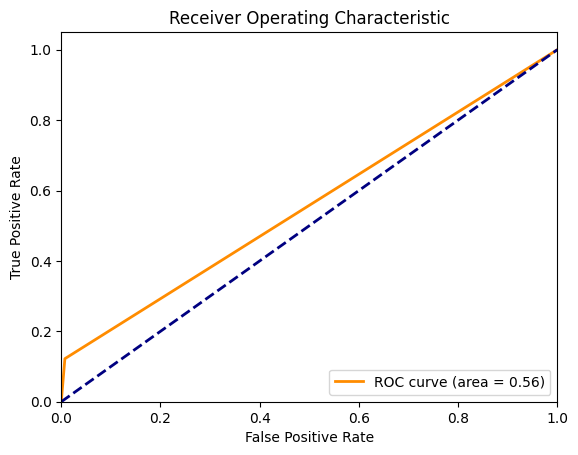

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, tuned_test_prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,
         tpr,
         color = 'darkorange',
         lw = 2,
         label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         color = 'navy',
         lw = 2,
         linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = 'lower right')
plt.show()

### IV.F.4. Export Hyperparameter-tuned Best Model

In [49]:
# with open("../../models/tuned_best_model.pkl", "wb") as file:
#     pickle.dump(tuned_best_model, file)

# V. Scorecard Creation

## V.A. Scorecard Table Creation

In [50]:
scorecard_model = tuned_best_model.best_estimator_
feature_name = X_train.columns.tolist()
summary_table = pd.DataFrame(columns = ["Feature Name"], data = feature_name)
summary_table["Coefficients"] = np.transpose(scorecard_model.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ["Intercept", scorecard_model.intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table

,Feature Name,Coefficients
0,Intercept,-8.603038
1,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA...,-0.094401
2,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,-0.221118
3,region:LATIN AMERICA AND CARIBBEAN,-0.563019
4,region:MIDDLE EAST AND NORTH AFRICA,-0.227288
5,country:group_b,1.188377
6,country:group_c,1.521493
7,country:group_d,1.297024
8,country:group_e,1.560210
9,country:group_f,2.331120


## V.B. Scorecard Test Prediction Probability Metrics

In [51]:
def create_probability_df(y_test, model, X_test):
    y_test_proba = model.predict_proba(X_test)
    y_test_proba = y_test_proba[:, 1]
    y_test_copy = y_test.copy().reset_index(drop = True)
    y_test_proba = pd.concat([y_test_copy, pd.DataFrame(y_test_proba, columns = ["y_test_proba"])], axis = 1)
    y_test_proba.columns = ["y_test_true", "y_test_proba"]
    y_test_proba.index = X_test.index
    return y_test_proba

In [52]:
y_test_proba = create_probability_df(y_test, tuned_best_model, X_test)
y_test_proba.head()

,y_test_true,y_test_proba
219,0,0.001171
3628,0,0.003685
497,0,0.005365
5583,0,0.007679
1556,0,0.008604


In [ ]:
def calculate_metrics(y_test_proba, threshold=0.5):
    y_test_proba["y_test_pred"] = np.where(y_test_proba["y_test_proba"] >= threshold, 1, 0)
    precision, recall, _ = precision_recall_curve(y_test_proba["y_test_true"], y_test_proba["y_test_proba"])
    fpr, tpr, _ = roc_curve(y_test_proba["y_test_true"], y_test_proba["y_test_proba"])
    auc_roc = auc(fpr, tpr)
    gini = auc_roc * 2 - 1
    auc_pr = auc(recall, precision)
    return {"precision": precision.mean(), "recall": recall.mean(), "fpr": fpr.mean(), "tpr": tpr.mean(), "auc_roc": auc_roc, "gini": gini, "auc_pr": auc_pr}

metrics_dict = calculate_metrics(y_test_proba, threshold=0.5)
metrics_df = pd.DataFrame(metrics_dict, index=[0])
metrics_df.head()


In [53]:
# threshold = 0.5
# y_test_proba["y_test_pred"] = np.where(y_test_proba["y_test_proba"] >= threshold, 1, 0)
# y_test_proba.head()

In [54]:
# cm = confusion_matrix(y_test_proba["y_test_true"], y_test_proba["y_test_pred"])
# cmd = ConfusionMatrixDisplay(cm, display_labels = ["Good", "Bad"])
# cmd.plot(cmap = 'Blues')
# plt.show()

In [55]:
# fpr, tpr, thresholds = roc_curve(y_test_proba["y_test_true"], y_test_proba["y_test_proba"])
# plt.plot(fpr, tpr)
# plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# plt.xlabel("False positive rate")
# plt.ylabel("True positive rate")
# plt.title("ROC curve")

In [56]:
# AUROC = roc_auc_score(y_test_proba['y_test_true'], y_test_proba['y_test_proba'])
# AUROC

In [57]:
# # Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
# AUROC = roc_auc_score(y_test_proba['y_test_true'], y_test_proba['y_test_proba'])
# AUROC

In [58]:
# # calculate Gini from AUROC
# Gini = AUROC * 2 - 1
# Gini

In [59]:
# # draw a PR curve
# # calculate the no skill line as the proportion of the positive class
# benchmark = len(y_test[y_test == 1]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [benchmark, benchmark], linestyle='--', label='benchmark')

# # calculate inputs for the PR curve
# precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_true'], y_test_proba['y_test_proba'])
# # plot PR curve
# plt.plot(recall, precision, marker='.', label='Logistic')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend()
# plt.title('PR curve');

In [60]:
# # calculate PR AUC
# auc_pr = auc(recall, precision)
# auc_pr

,precision,recall,fpr,tpr,auc_roc,gini,auc_pr
0,0.136641,0.70356,0.414236,0.712166,0.784729,0.569457,0.234264


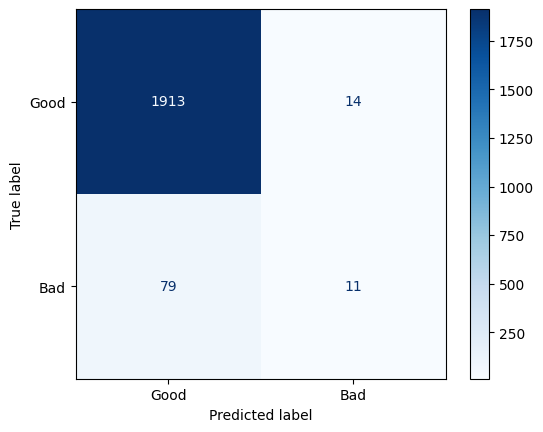

In [63]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_test_proba["y_test_true"], y_test_proba["y_test_pred"])
cmd = ConfusionMatrixDisplay(cm, display_labels = ["Good", "Bad"])
cmd.plot(cmap = 'Blues')
plt.show()


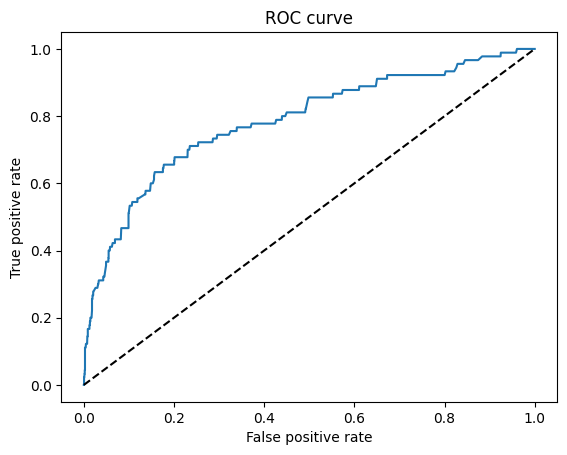

In [64]:
# Generate and display the ROC curve
fpr, tpr, _ = roc_curve(y_test_proba["y_test_true"], y_test_proba["y_test_proba"])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()


Text(0.5, 1.0, 'PR curve')

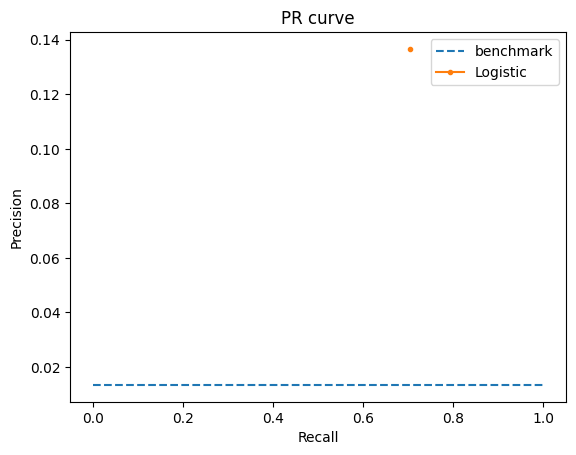

In [66]:
# calculate the no skill line as the proportion of the positive class
benchmark = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [benchmark, benchmark], linestyle='--', label='benchmark')

# use precision and recall from the metrics dictionary
precision = metrics_dict['precision']
recall = metrics_dict['recall']

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve')


In [ ]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(reference_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

In [ ]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

In [ ]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

In [ ]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [ ]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

In [ ]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

In [ ]:
df_scorecard.columns

In [ ]:
def score_data(df, scorecard):
    # Create a copy of the dataframe to avoid changes in the original one
    scored_df = df.copy()
    
    # Iterate over the rows in the scorecard
    for index, row in scorecard.iterrows():
        # If the feature is in the data, replace its values with the score
        if row['Feature name'] in scored_df.columns:
            scored_df[row['Feature name']] = row['Score - Preliminary']
    
    return scored_df

# Score the train data
scored_train = score_data(X_train, df_scorecard)

# Score the test data
scored_test = score_data(X_test, df_scorecard)

In [ ]:
scored_train.head()